In [1]:
import os,sys
import cPickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from time import time

sys.path.insert(0,'lib/')
import config
import diagnostics
import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_VISIBLE_DEVICES']=''

import tensorflow as tf

%matplotlib inline

In [2]:
with open(config.labels_path) as f:
    labels = pickle.load(f)

In [3]:
# filters between 10Hz and 22kHz
def create_filters(d,k):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((1,d,1,k), dtype=np.float32)
    wcos = np.empty((1,d,1,k), dtype=np.float32)
    start_freq = 50.
    end_freq = 6000.
    num_cycles = start_freq*d/44000.
    scaling_ind = (end_freq/start_freq)/k
    window_mask = 1.0#-1.0*np.cos(x)
    for ind in range(k):
        wsin[0,:,0,ind] = window_mask*np.sin((ind*scaling_ind)*num_cycles*x)
        wcos[0,:,0,ind] = window_mask*np.cos((ind*scaling_ind)*num_cycles*x)
            
    return wsin,wcos

class Spectrograms(base_model.Model):
    def __init__(self, *args, **kwargs):
        super(Spectrograms, self).__init__(*args, **kwargs)

    def define_graph(self):
        super(Spectrograms, self).define_graph()
        
        # lvl1 convolutions are shared between regions
        self.k = 512              # lvl1 nodes
        self.d = 4096              # lvl1 receptive field

        # number of lvl1 features
        regions = 1 + (self.window - self.d)/self.stride
        print 'Number of V1 feature regions: {}'.format(regions)

        # preconditionable weights
        wsin,wcos = create_filters(self.d,self.k)

        with tf.variable_scope('parameters'):
            beta = tf.Variable(tf.zeros([regions*self.k,self.m]))
            betaavg = self.register_weights(beta,'beta',average=.9998)

        with tf.variable_scope('queued_model'):
            zx = tf.square(tf.nn.conv2d(self.xq,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
               + tf.square(tf.nn.conv2d(self.xq,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            y = tf.matmul(tf.reshape(tf.log(zx + 10e-12),[self.batch_size,regions*self.k]),beta)
            self.loss = tf.reduce_mean(tf.nn.l2_loss(y-tf.reshape(self.yq,[self.batch_size,self.m])))

        with tf.variable_scope('direct_model'):
            self.zx = tf.square(tf.nn.conv2d(self.xd,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
                    + tf.square(tf.nn.conv2d(self.xd,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            self.y_direct = tf.matmul(tf.reshape(tf.log(self.zx + 10e-12),[tf.shape(self.xd)[0],regions*self.k]),betaavg)
            self.loss_direct = tf.reduce_mean(tf.nn.l2_loss(self.y_direct-self.yd))

In [4]:
try: model.stop()
except NameError: pass
model = Spectrograms(labels,checkpoint_path='spectrograms_stft/', outputs=1, window=16384, mmap=True,
                    normalize=True, extended_test_set=True, use_mirex=False, init=False, pitch_transforms=5, jitter=.1,
                    restrict=False)

Number of V1 feature regions: 25


In [ ]:
lr = .000000001/2/2/3
mom = .95

# stop the model if it is already running
model.stop()

# we have to rebuild the graph every time because input queues can't be reopened
model.define_graph()

learning_rate = tf.placeholder(tf.float32, shape=[])
opt_op = tf.train.MomentumOptimizer(learning_rate,mom).minimize(model.loss)
with tf.control_dependencies([opt_op]):
    train_step = tf.group(*model.averages)

# start up the session, kick off the worker threads, restore checkpoint, etc.
model.start()

try:
    ptime = time()
    print model.status_header()
    while True:
        if model.iter % 1000 == 0:
            model.update_status(ptime,time(),lr)
            model.checkpoint()
            print model.status()
            ptime = time()

        model.sess.run(train_step, feed_dict={learning_rate: lr})
        model.iter += 1

except KeyboardInterrupt:
    model.checkpoint()
    print 'Graceful Exit'

Number of V1 feature regions: 25
avp_test	avp_train	mse_test	mse_train	time	utime
0.618337        0.641167        0.714997        0.875767        20      20      
0.618361        0.641163        0.714983        0.875770        64      23      
0.618369        0.641161        0.714970        0.875774        62      20      
0.618651        0.641330        0.714884        0.875667        63      21      
0.618663        0.641333        0.714862        0.875664        65      22      
0.618668        0.641343        0.714853        0.875664        64      22      
0.618675        0.641341        0.714840        0.875661        64      22      
0.618797        0.641359        0.714721        0.875617        64      20      
0.618808        0.641365        0.714723        0.875614        65      22      
0.618816        0.641377        0.714714        0.875612        63      21      
0.618821        0.641379        0.714716        0.875609        63      21      
0.618819        0.641388   

0.619712327136
0.714324002707


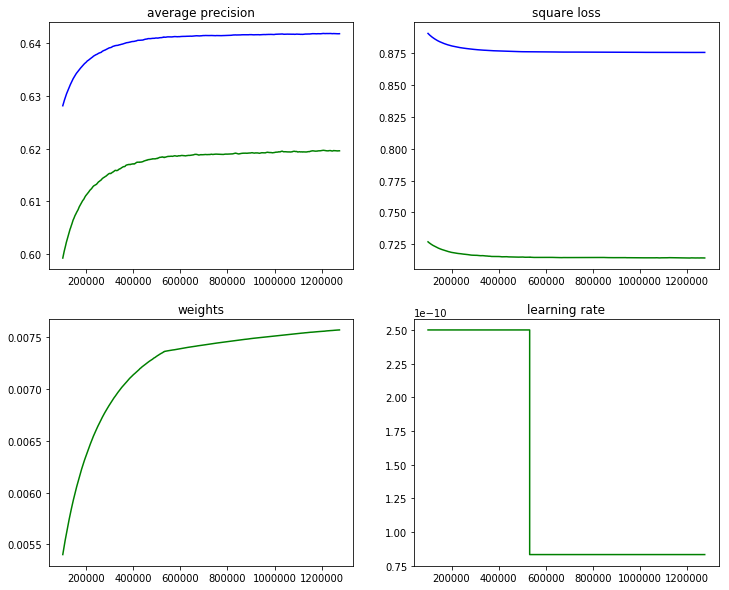

In [14]:
burnin=100
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_test'][2][burnin:],color='g')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_train'][2][burnin:],color='b')
ax2.set_title('square loss')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_test'][2][burnin:],color='g')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_train'][2][burnin:],color='b')
ax3.set_title('weights')
ax3.plot(model.stats['iter'][2][burnin:],model.stats['nbeta'][2][burnin:],color='g')
ax4.set_title('learning rate')
ax4.plot(model.stats['iter'][2][burnin:],model.stats['lr'][2][burnin:],color='g')

print max(model.stats['avp_test'][2])
print min(model.stats['mse_test'][2])

# Mirex Stats

In [5]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.60451822475


In [6]:
Accavg = Etotavg = 0
for i in range(3):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/3.,Etotavg/3.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
67.40	71.21	55.89	0.46	0.56	0.11	0.33	0.12
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
34.30	48.84	26.45	0.21	0.89	0.13	0.61	0.15
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
72.74	78.29	47.92	0.42	0.60	0.05	0.47	0.08
0.36200608168 0.681193479307


# Extended test set stats

In [7]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids_ext, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.629120842711


In [8]:
Accavg = Etotavg = 0
for i in range(10):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/10.,Etotavg/10.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
67.40	71.21	55.89	0.46	0.56	0.11	0.33	0.12
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
34.30	48.84	26.45	0.21	0.89	0.13	0.61	0.15
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
72.74	78.29	47.92	0.42	0.60	0.05	0.47	0.08
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
60.83	57.96	61.54	0.43	0.65	0.18	0.20	0.26
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
66.25	52.64	87.49	0.49	0.79	0.12	0.01	0.67
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
68.91	72.85	55.52	0.46	0.51	0.14	0.31	0.07
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
60.84	61.39	60.56	0.44	0.70	0.08	0.32	0.30
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
67.03	70.94	53.04	0.44	0.56	0.12	0.35	0.09
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
66.02	69.38	58.89	0.47	0.53	0.14	0.27	0.12
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
64.52	70.95	52.93	0.44	0.55	0.14	0.33	0.08
0.423771815484 0.633949578119
